<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch
## BinhLai_Dataset_Daily

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Check Additional Packages](#1.1)
    * [2.2. Import Packages](#1.2)
    * [2.3. Create Folders](#1.3)
* [3. Download Data](#2)
* [4. Preprocess fundamental data](#3)        
    * [4.1. Import the financial data](#3.1)
    * [4.2. Specify items needed to calculate financial ratios](#3.2)
    * [4.3. Turn the final_ratios to daily basis](#3.3)
    * [4.4. Merge stock price data and ratios into one dataframe](#3.4)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.1'></a>
## 2.1. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.2'></a>
## 2.2. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

ERROR! Session/line number was not unique in database. History logging moved to new session 2


<a id='1.3'></a>
## 2.3. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [5]:
from datetime import datetime
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER[:2]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (7652, 8)


In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,58.590000,59.080002,57.75,42.406391,6547900,AMGN,4
1,2009-01-02,18.570000,19.520000,18.40,15.144919,10955700,AXP,4
2,2009-01-05,59.220001,59.650002,58.00,42.880852,10940100,AMGN,0
3,2009-01-05,19.200001,20.240000,19.00,15.630686,16019200,AXP,0
4,2009-01-06,60.040001,60.150002,57.75,41.939110,8974000,AMGN,1


In [7]:
df.tail()

,date,open,high,low,close,volume,tic,day
7647,2024-03-13,223.139999,223.490005,221.869995,222.809998,2693100,AXP,2
7648,2024-03-14,276.839996,277.230011,270.450012,271.540009,2370500,AMGN,3
7649,2024-03-14,224.279999,224.289993,219.100006,220.470001,2417900,AXP,3
7650,2024-03-15,272.089996,275.179993,268.170013,268.869995,8794200,AMGN,4
7651,2024-03-15,220.979996,221.600006,217.220001,218.460007,5266600,AXP,4


In [8]:
df.shape

(7652, 8)

In [9]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,58.590000,59.080002,57.75,42.406391,6547900,AMGN,4
1,2009-01-02,18.570000,19.520000,18.40,15.144919,10955700,AXP,4
2,2009-01-05,59.220001,59.650002,58.00,42.880852,10940100,AMGN,0
3,2009-01-05,19.200001,20.240000,19.00,15.630686,16019200,AXP,0
4,2009-01-06,60.040001,60.150002,57.75,41.939110,8974000,AMGN,1


In [10]:
len(df.tic.unique())

2

In [11]:
df.tic.value_counts()

tic
AMGN    3826
AXP     3826
Name: count, dtype: int64

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Alpha Vantage
- Preprocess the dataset and calculate financial ratios
- Turn yearly ratio into daily basis

<a id='3.1'></a>
## 4.1 Import the financial data

#### Define configurations of the collecting data & download data via Alpha Vantage API

In [12]:
import requests

api_key = 'EEAI5CE759SUIP6I'
features_cols = ['fiscalDateEnding','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
price_cols = ['open','high','low','close','volume']

Function to download fundamental data from financial reports by ticket

In [13]:
def collect_fundamental(ticket):
    # Download income statement
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticket}&apikey={api_key}'
    r = requests.get(url)
    data_is = r.json()

    # Download balance sheet
    url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticket}&apikey={api_key}'
    r = requests.get(url)
    data_bs = r.json()

    # Download cash flow
    url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticket}&apikey={api_key}'
    r = requests.get(url)
    data_cf = r.json()

    df_is = pd.json_normalize(data_is['annualReports'])
    df_bs = pd.json_normalize(data_bs['annualReports'])
    df_cf = pd.json_normalize(data_cf['annualReports'])

    merged_df = df_is.merge(df_bs).merge(df_cf)
    merged_df = merged_df[features_cols]
    merged_df['fiscalDateEnding'] = pd.to_datetime(merged_df.fiscalDateEnding,format='mixed')

    return merged_df

Function to download stock price by ticket

In [14]:
def collect_price(ticket):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={ticket}&apikey={api_key}'
    r = requests.get(url)
    data_monthly_price = r.json()

    price_monthly = pd.DataFrame.from_dict(data_monthly_price['Monthly Time Series'], orient='index')
    price_monthly.columns = price_cols
    price_monthly['fiscalDateEnding'] = pd.to_datetime(price_monthly.index,format='mixed')
    price_monthly.reset_index(inplace=True,drop=True)
    price_monthly = price_monthly[['fiscalDateEnding','open','high','low','close','volume']]
    return price_monthly

Function to merge monthly stock price into yearly fundamental data

In [15]:
def merge_price_to_df(merged_df,price_monthly):
    merged_df['year'] = merged_df.fiscalDateEnding.dt.year
    merged_df['month'] = merged_df.fiscalDateEnding.dt.month
    price_monthly['year'] = price_monthly.fiscalDateEnding.dt.year
    price_monthly['month'] = price_monthly.fiscalDateEnding.dt.month
    merged_final = pd.merge(merged_df,price_monthly,how="left",on=['year','month'])
    merged_final.drop(columns=['year','month','fiscalDateEnding_y'],inplace=True)
    merged_final = df_final.rename(columns={'fiscalDateEnding_x': 'date'})
    merged_final['tic'] = ticket

    merged_columns = [merged_final.columns[-1]]
    for i in range(0,len(merged_final.columns)-1):
        merged_columns.append(merged_final.columns[i])
    merged_final = merged_final[merged_columns]
    
    return merged_final

In [16]:
fund_cols = ['tic','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
fund_cols = fund_cols + price_cols
len(fund_cols)

32

In [17]:
first_10 = DOW_30_TICKER[2:10]
first_10

['AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON']

In [18]:
# fund_data = pd.DataFrame()

# for ticket in DOW_30_TICKER[2:10]:
#     df_fund = collect_fundamental(ticket)
#     price = collect_price(ticket)
#     merged_df = merge_price_to_df(df,price)
#     fund_data = pd.concat([fund_data, merged_df], ignore_index=True)

# ticket = 'AAPL'
# df = collect_fundamental(ticket)
# price = collect_price(ticket)
# merged_df = merge_price_to_df(df,price)
# fund_data = pd.concat([fund_data, merged_df], ignore_index=True)

In [19]:
# fund_data.to_csv('dow30_1.csv')

#### Check reach download limitation

In [20]:
# url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=AAPL&apikey=GUKB8WJD0YFELJD3'
# r = requests.get(url)
# data_is = r.json()
# data_is

#### Load data from csv file

In [21]:
fund_data = pd.read_csv('dow30_1.csv',index_col=0)
fund_data = fund_data.rename(columns={'fiscalDateEnding_x':'date'})
fund_data.head()

,tic,date,totalRevenue,costOfRevenue,sellingGeneralAndAdministrative,researchAndDevelopment,depreciation,interestExpense,totalCurrentLiabilities,incomeTaxExpense,...,retainedEarnings,dividendPayoutCommonStock,paymentsForRepurchaseOfCommonStock,treasuryStock,currentLongTermDebt,open,high,low,close,volume
0,AXP,2023-12-31,67364000000,50002000000,13513000000,NaN,NaN,6849000000,3860000000,2139000000,...,19612000000,1780000000,3.650000e+09,NaN,1.293000e+09,170.67,188.30,165.93,187.34,66652096
1,AXP,2022-12-31,55625000000,43277000000,13036000000,NaN,NaN,2763000000,3878000000,2071000000,...,16279000000,1565000000,3.502000e+09,NaN,1.000000e+09,157.72,161.55,142.72,147.75,53953591
2,AXP,2021-12-31,43663000000,31691000000,11498000000,NaN,NaN,1283000000,4771000000,2629000000,...,13474000000,1448000000,7.652000e+09,-271000000.0,2.000000e+09,156.10,170.58,149.89,163.60,83511760
3,AXP,2020-12-31,38185000000,31791000000,11294000000,NaN,NaN,2098000000,4214000000,1161000000,...,13837000000,1474000000,1.029000e+09,-279000000.0,2.000000e+09,120.32,125.32,113.72,120.91,77371622
4,AXP,2019-12-31,47020000000,35127000000,11804000000,NaN,NaN,3464000000,8871000000,1670000000,...,13871000000,1422000000,NaN,-292000000.0,6.442000e+09,120.31,126.33,114.65,124.49,63680336


#### Data cleaning ####
Refine the data before computing fundamental ratios

In [22]:
print(fund_data.info(),'\n')
print(fund_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tic                                    30 non-null     object 
 1   date                                   30 non-null     object 
 2   totalRevenue                           30 non-null     int64  
 3   costOfRevenue                          30 non-null     int64  
 4   sellingGeneralAndAdministrative        30 non-null     int64  
 5   researchAndDevelopment                 15 non-null     float64
 6   depreciation                           15 non-null     float64
 7   interestExpense                        30 non-null     int64  
 8   totalCurrentLiabilities                30 non-null     int64  
 9   incomeTaxExpense                       30 non-null     int64  
 10  netIncome                              30 non-null     int64  
 11  commonStockSh

Those features, expect date as datatime64 and tic as string, is required to turn them into numeric datatype or float.<br>
Before adjusting datatypes, checking unique values in each features is neccessary to ensure dataset clearn from missing data and nan data points 

In [23]:
fund_data = fund_data.fillna(0)
# for i in fund_data.columns:
#     print(i,'\n',fund_data[i].unique(),'\n')

'None' value is replaced with '0' and correcting datatype can now being apply on the features. In this case, all data points must be turned into float instead of object.

In [24]:
float_columns = fund_data.columns
float_columns = float_columns.drop(['date','tic'])

for column in float_columns:
    fund_data[column] = fund_data[column].astype(float)

fund_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tic                                    30 non-null     object 
 1   date                                   30 non-null     object 
 2   totalRevenue                           30 non-null     float64
 3   costOfRevenue                          30 non-null     float64
 4   sellingGeneralAndAdministrative        30 non-null     float64
 5   researchAndDevelopment                 30 non-null     float64
 6   depreciation                           30 non-null     float64
 7   interestExpense                        30 non-null     float64
 8   totalCurrentLiabilities                30 non-null     float64
 9   incomeTaxExpense                       30 non-null     float64
 10  netIncome                              30 non-null     float64
 11  commonStockSh

## 4.2 Compute fundamental ratio

Define support functions before computing fundamental ratios

In [25]:
# Define a function to count positive values within a window
def count_positives(window):
  return window[window > 0].count()

def count_positives_window(data,k):
    df = pd.DataFrame(data, columns=['values'])

    # Create a new column with the adjusted positive count (using a shifted window)
    df['positive_count'] = df['values'].rolling(window=k, min_periods=1).apply(count_positives)

    # Set positive_count of the first k rows to positive_count of row k
    df.loc[:k-1,'positive_count'] = df.loc[k-1].positive_count

    return df

In [26]:
# Define a function to min value within a window
def get_min(window):
  return window.min()

def min_in_window(data,k):
    df = pd.DataFrame(data, columns=['values'])

    # Create a new column with the min in the window (using a shifted window)
    df['min'] = df['values'].rolling(window=k, min_periods=1).apply(get_min)

    return df

At this point, data and supporting functions are ready for computing fundamental ratios required

In [27]:
def compute_fund_ratios(df_final):
    pos_count_window = 10  # number of years to look back for count_positive_profit
    min_ebit_window = 4  # number of years to look back for min_ebit
    
    gross_income = df_final.totalRevenue - df_final.costOfRevenue
    ebit = gross_income - df_final.sellingGeneralAndAdministrative
    profit = ebit - df_final.interestExpense - df_final.incomeTaxExpense
    market_equity = df_final.commonStockSharesOutstanding * df_final.close
    market_asset = df_final.totalLiabilities + market_equity
    
    # Gross profit margin
    gross_profit_margin = (gross_income/df_final.totalRevenue).to_frame('gross_profit_margin')
    
    # SGA Expense / Gross Profit
    sga_ratio = (df_final.sellingGeneralAndAdministrative/gross_income).to_frame('sga_ratio')
    
    # Depreciation / Gross Profit
    dep_ratio = (df_final.depreciation/gross_income).to_frame('dep_ratio')
    
    # EBIT / Bond interest
    ebit_on_int = (ebit/df_final.interestExpense).to_frame('ebit_on_int')
    
    # Profit margin
    profit_margin = (profit/df_final.totalRevenue).to_frame('profit_margin')
    
    # Amount of positive profit within a window
    count_positive_profit = count_positives_window(profit,pos_count_window)
    count_positive_profit = count_positive_profit['positive_count'].to_frame('count_positive_profit')
    
    # Cash And Short Term Investments / Total Liabilities
    csti_on_liabilities = (df_final.cashAndShortTermInvestments/df_final.totalLiabilities).to_frame('csti_on_liabilities')
    
    # Inventory / EBIT
    inventory_on_ebit = (df_final.inventory / ebit).to_frame('inventory_on_ebit')
    
    # Receivable / Revenue
    receivable_on_rev = (df_final.currentNetReceivables / df_final.totalRevenue).to_frame('receivable_on_rev')
    
    # ROA
    roa = (profit / market_asset).to_frame('roa')
    
    # ROE
    roe = (profit / market_equity).to_frame('roe')
    
    # Long-term debt / minEBIT
    min_ebit = min_in_window(ebit,min_ebit_window)['min']
    debt_on_min_ebit = (df_final.longTermDebt / min_ebit).to_frame('debt_on_min_ebit')
    
    # Total Liabilities / Total Equity
    liabilities_on_equity = (df_final.totalLiabilities / market_equity).to_frame('liabilities_on_equity')
    
    # Capital Expenditures / EBIT
    capital_cost_on_ebit = (df_final.capitalExpenditures / ebit).to_frame('capital_cost_on_ebit')
    
    # EPS / MP
    eps = profit / df_final.commonStockSharesOutstanding
    eps_on_mp = (eps / df_final.close).to_frame('eps_on_mp')
    
    # Cash and Stock Dividend & Repurchase Common / MP
    dividend_on_mp = ((df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock) / df_final.close).to_frame('dividend_on_mp')
    
    # MP / BV
    mp_on_bv = (df_final.close / (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities)).to_frame('mp_on_bv')

    # Create a dataframe that merges all the ratios
    ratios = pd.concat([df_final.date,df_final.tic,gross_profit_margin,sga_ratio,dep_ratio,
                    ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,
                    inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,
                   liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv], axis=1)

    return ratios

In [28]:
ratios = compute_fund_ratios(fund_data)
ratios.head()

,date,tic,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2023-12-31,AXP,0.257734,0.778309,0.0,0.561980,-0.076287,1.0,0.198446,28.710314,0.0,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
1,2022-12-31,AXP,0.221987,1.055718,0.0,-0.249005,-0.099272,1.0,0.165373,-53.305233,0.0,-0.017618,-0.050301,-61.879360,1.855040,-2.696221,-0.050301,3.429442e+07,-1.014864e-09
2,2021-12-31,AXP,0.274191,0.960408,0.0,0.369447,-0.078739,1.0,0.130377,159.512658,0.0,-0.011820,-0.027615,-56.213663,1.336318,3.270042,-0.027615,5.562347e+07,-1.590235e-09
3,2020-12-31,AXP,0.167448,1.766343,0.0,-2.335558,-0.213670,1.0,0.193107,-15.591633,0.0,-0.030706,-0.083826,-8.765714,1.729976,-0.301633,-0.083826,2.070135e+07,-1.619377e-09
4,2019-12-31,AXP,0.252935,0.992517,0.0,0.025693,-0.107295,1.0,0.137832,907.033708,0.0,-0.018273,-0.050031,-11.803061,1.737955,18.483146,-0.050031,1.142260e+07,-5.026406e-09


<a id='3.3'></a>
## 4.3 Turn the final_ratios to daily basis¶
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. <br>
The **date** should be in datetime type <br>
The **ratios** should be read in as float64 — and categorical variables should be stored as object 

In [29]:
ratios['date'] = pd.to_datetime(ratios['date'],format='mixed')
ratios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   30 non-null     datetime64[ns]
 1   tic                    30 non-null     object        
 2   gross_profit_margin    30 non-null     float64       
 3   sga_ratio              30 non-null     float64       
 4   dep_ratio              30 non-null     float64       
 5   ebit_on_int            30 non-null     float64       
 6   profit_margin          30 non-null     float64       
 7   count_positive_profit  30 non-null     float64       
 8   csti_on_liabilities    30 non-null     float64       
 9   inventory_on_ebit      30 non-null     float64       
 10  receivable_on_rev      30 non-null     float64       
 11  roa                    30 non-null     float64       
 12  roe                    30 non-null     float64       
 13  debt_on_min_

In [30]:
ratios.isna().sum()

date                     0
tic                      0
gross_profit_margin      0
sga_ratio                0
dep_ratio                0
ebit_on_int              0
profit_margin            0
count_positive_profit    0
csti_on_liabilities      0
inventory_on_ebit        0
receivable_on_rev        0
roa                      0
roe                      0
debt_on_min_ebit         0
liabilities_on_equity    0
capital_cost_on_ebit     0
eps_on_mp                0
dividend_on_mp           0
mp_on_bv                 0
dtype: int64

We see that there is no missing values in all ratios

In [31]:
# Replace NAs infinite values with zero
ratios = ratios.fillna(0)
ratios = ratios.replace(np.inf,0)

In [32]:
ratios.head()

,date,tic,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2023-12-31,AXP,0.257734,0.778309,0.0,0.561980,-0.076287,1.0,0.198446,28.710314,0.0,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
1,2022-12-31,AXP,0.221987,1.055718,0.0,-0.249005,-0.099272,1.0,0.165373,-53.305233,0.0,-0.017618,-0.050301,-61.879360,1.855040,-2.696221,-0.050301,3.429442e+07,-1.014864e-09
2,2021-12-31,AXP,0.274191,0.960408,0.0,0.369447,-0.078739,1.0,0.130377,159.512658,0.0,-0.011820,-0.027615,-56.213663,1.336318,3.270042,-0.027615,5.562347e+07,-1.590235e-09
3,2020-12-31,AXP,0.167448,1.766343,0.0,-2.335558,-0.213670,1.0,0.193107,-15.591633,0.0,-0.030706,-0.083826,-8.765714,1.729976,-0.301633,-0.083826,2.070135e+07,-1.619377e-09
4,2019-12-31,AXP,0.252935,0.992517,0.0,0.025693,-0.107295,1.0,0.137832,907.033708,0.0,-0.018273,-0.050031,-11.803061,1.737955,18.483146,-0.050031,1.142260e+07,-5.026406e-09


In [33]:
ratios.tail()

,date,tic,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
25,2013-12-31,AMGN,0.794924,0.349185,0.043379,9.454012,0.452774,10.0,0.440641,0.312461,0.144410,0.064989,0.098229,3.325191,0.511461,0.071724,0.098229,1.969670e+07,-5.735228e-09
26,2012-12-31,AMGN,0.778454,0.358185,0.051265,7.994439,0.398668,10.0,0.682814,0.318108,0.145844,0.068535,0.105579,3.075470,0.540518,0.079875,0.105579,6.641531e+07,-1.281708e-08
27,2011-12-31,AMGN,0.825825,0.349627,0.052767,13.719672,0.467976,10.0,0.691676,0.296810,0.185855,0.090105,0.142741,2.560401,0.584158,0.067750,0.142741,1.372839e+08,-1.408670e-08
28,2010-12-31,AMGN,0.826413,0.320177,0.047749,14.001656,0.475852,10.0,0.891516,0.239092,0.155119,0.101303,0.139993,1.596607,0.381927,0.068582,0.139993,6.896175e+07,2.946227e-08
29,2009-12-31,AMGN,0.837317,0.311582,0.050897,14.602076,0.496039,10.0,0.792477,0.263033,0.144038,0.099155,0.129035,1.266699,0.301348,0.062796,0.129035,5.670850e+07,1.331685e-07


### Turn the final_ratios to daily basis

In [34]:
start_date = df.iloc[0].date
end_date = df.iloc[-1].date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns = ['date']
date_range.head()

,date
0,2009-01-02
1,2009-01-03
2,2009-01-04
3,2009-01-05
4,2009-01-06


Interpolate missing data in the middle of years for each ticket

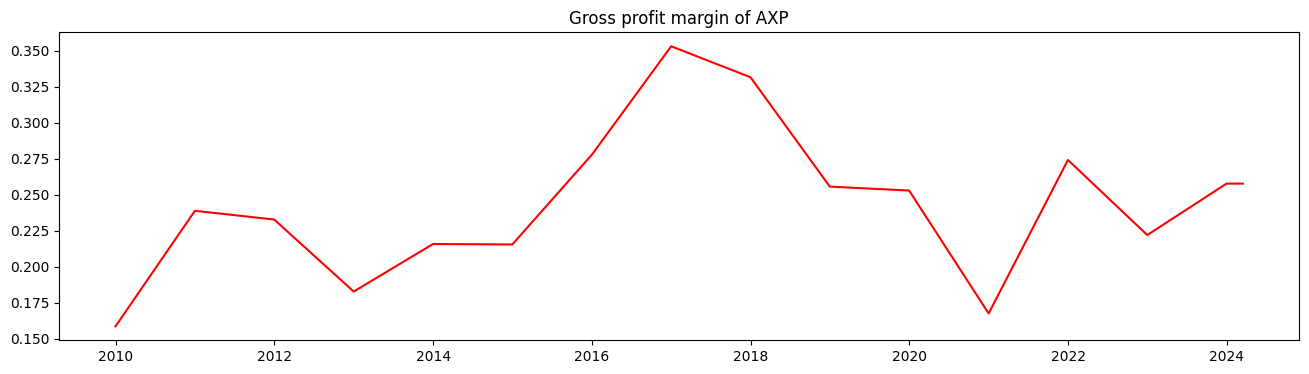

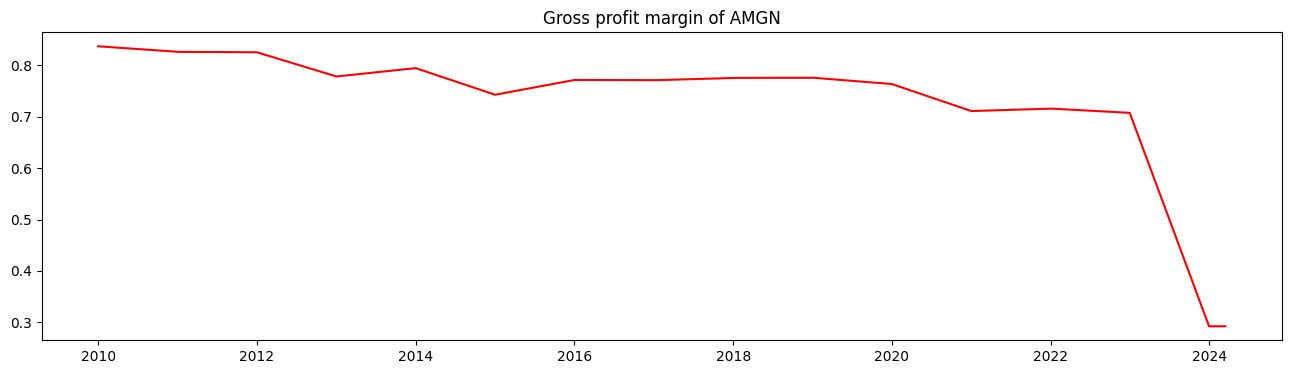

In [35]:
daily_ratios = pd.DataFrame()
for ticket in ratios.tic.unique():
    # Interpolate data for each ticket
    one_tic_ratios = pd.merge(date_range,ratios[ratios.tic == ticket],how="left",on=['date'])
    one_tic_ratios['tic'] = ticket
    one_tic_ratios = one_tic_ratios.interpolate('linear')
    daily_ratios = pd.concat([daily_ratios, one_tic_ratios], ignore_index=True)

    # Check data by drawing it out
    %matplotlib inline
    plt.figure(figsize=(16, 4)) 
    plt.plot(one_tic_ratios.date, one_tic_ratios.gross_profit_margin, color = 'red')
    plt.title(f'Gross profit margin of {ticket}')
    plt.show()

In [36]:
daily_ratios.dropna(subset='gross_profit_margin',inplace=True)
daily_ratios

,date,tic,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
363,2009-12-31,AXP,0.158545,1.306584,0.000000,-0.540100,-0.167312,1.0,0.140348,-0.000000,0.000000,-0.025799,-0.084949,-52.477936,2.292741,-0.647651,-0.084949,2.280355e+07,-4.281461e-10
364,2010-01-01,AXP,0.158765,1.305403,0.000000,-0.537684,-0.167199,1.0,0.139977,0.000000,0.000000,-0.025781,-0.084903,-52.457692,2.293416,-0.642942,-0.084903,2.283408e+07,-4.278830e-10
365,2010-01-02,AXP,0.158985,1.304222,0.000000,-0.535268,-0.167085,1.0,0.139606,0.000000,0.000000,-0.025763,-0.084857,-52.437449,2.294092,-0.638232,-0.084857,2.286461e+07,-4.276200e-10
366,2010-01-03,AXP,0.159205,1.303040,0.000000,-0.532852,-0.166972,1.0,0.139236,0.000000,0.000000,-0.025745,-0.084811,-52.417205,2.294767,-0.633523,-0.084811,2.289514e+07,-4.273569e-10
367,2010-01-04,AXP,0.159425,1.301859,0.000000,-0.530436,-0.166858,1.0,0.138865,0.000000,0.000000,-0.025727,-0.084765,-52.396961,2.295443,-0.628814,-0.084765,2.292567e+07,-4.270939e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11099,2024-03-11,AMGN,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09
11100,2024-03-12,AMGN,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09
11101,2024-03-13,AMGN,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09
11102,2024-03-14,AMGN,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09


<a id='3.4'></a>
## 4.4 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [37]:
df_date = pd.DataFrame(df)[['date','tic','close']]
df_date.columns = ['date','tic','close']
df_date['date'] = pd.to_datetime(df_date.date)
final_ratios = pd.merge(df_date,daily_ratios,how="left",on=['date','tic'])

In [38]:
final_ratios.dropna(subset=['gross_profit_margin'],inplace=True,how='any')
final_ratios.reset_index(drop=True,inplace=True)
final_ratios.isna().sum()

date                     0
tic                      0
close                    0
gross_profit_margin      0
sga_ratio                0
dep_ratio                0
ebit_on_int              0
profit_margin            0
count_positive_profit    0
csti_on_liabilities      0
inventory_on_ebit        0
receivable_on_rev        0
roa                      0
roe                      0
debt_on_min_ebit         0
liabilities_on_equity    0
capital_cost_on_ebit     0
eps_on_mp                0
dividend_on_mp           0
mp_on_bv                 0
dtype: int64

In [39]:
processed_full = final_ratios.copy()
processed_full

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2009-12-31,AMGN,40.666698,0.837317,0.311582,0.050897,14.602076,0.496039,10.0,0.792477,0.263033,0.144038,0.099155,0.129035,1.266699,0.301348,0.062796,0.129035,5.670850e+07,1.331685e-07
1,2009-12-31,AXP,32.868496,0.158545,1.306584,0.000000,-0.540100,-0.167312,1.0,0.140348,-0.000000,0.000000,-0.025799,-0.084949,-52.477936,2.292741,-0.647651,-0.084949,2.280355e+07,-4.281461e-10
2,2010-01-04,AMGN,41.493416,0.837198,0.311677,0.050863,14.595496,0.495818,10.0,0.793563,0.262771,0.144159,0.099178,0.129155,1.270314,0.302231,0.062860,0.129155,5.684278e+07,1.320320e-07
3,2010-01-04,AXP,33.192951,0.159425,1.301859,0.000000,-0.530436,-0.166858,1.0,0.138865,0.000000,0.000000,-0.025727,-0.084765,-52.396961,2.295443,-0.628814,-0.084765,2.292567e+07,-4.270939e-10
4,2010-01-05,AMGN,41.133972,0.837168,0.311700,0.050854,14.593851,0.495762,10.0,0.793834,0.262705,0.144189,0.099184,0.129185,1.271218,0.302451,0.062875,0.129185,5.687636e+07,1.317479e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,2024-03-13,AXP,222.809998,0.257734,0.778309,0.000000,0.561980,-0.076287,1.0,0.198446,28.710314,0.000000,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
7146,2024-03-14,AMGN,271.540009,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09
7147,2024-03-14,AXP,220.470001,0.257734,0.778309,0.000000,0.561980,-0.076287,1.0,0.198446,28.710314,0.000000,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
7148,2024-03-15,AMGN,268.869995,0.292201,0.827065,0.091688,0.449391,-0.106422,1.0,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09


Reset **TRAIN_START_DATE** and **TEST_END_DATE**

In [40]:
TRAIN_START_DATE = final_ratios.date.min().strftime("%Y-%m-%d")
TEST_END_DATE = final_ratios.date.max().strftime("%Y-%m-%d")
print('TRAIN_START_DATE: ',TRAIN_START_DATE,'\n')
print('TEST_END_DATE: ',TEST_END_DATE,'\n')

TRAIN_START_DATE:  2009-12-31 

TEST_END_DATE:  2024-03-15 



<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2020-01-01
- Trade data period: 2020-01-01 to 2023-12-29

In [41]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

5034
2114


In [42]:
train_data = train_data.reset_index(drop=True)
train_data

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2009-12-31,AMGN,40.666698,0.837317,0.311582,0.050897,14.602076,0.496039,10.00000,0.792477,0.263033,0.144038,0.099155,0.129035,1.266699,0.301348,0.062796,0.129035,5.670850e+07,1.331685e-07
1,2009-12-31,AXP,32.868496,0.158545,1.306584,0.000000,-0.540100,-0.167312,1.00000,0.140348,-0.000000,0.000000,-0.025799,-0.084949,-52.477936,2.292741,-0.647651,-0.084949,2.280355e+07,-4.281461e-10
2,2010-01-04,AMGN,41.493416,0.837198,0.311677,0.050863,14.595496,0.495818,10.00000,0.793563,0.262771,0.144159,0.099178,0.129155,1.270314,0.302231,0.062860,0.129155,5.684278e+07,1.320320e-07
3,2010-01-04,AXP,33.192951,0.159425,1.301859,0.000000,-0.530436,-0.166858,1.00000,0.138865,0.000000,0.000000,-0.025727,-0.084765,-52.396961,2.295443,-0.628814,-0.084765,2.292567e+07,-4.270939e-10
4,2010-01-05,AMGN,41.133972,0.837168,0.311700,0.050854,14.593851,0.495762,10.00000,0.793834,0.262705,0.144189,0.099184,0.129185,1.271218,0.302451,0.062875,0.129185,5.687636e+07,1.317479e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,2019-12-27,AXP,117.890259,0.252965,0.992592,0.000000,0.025437,-0.107166,1.00000,0.138141,897.093612,0.000000,-0.018256,-0.050045,-11.804376,1.741484,20.331472,-0.050045,1.163360e+07,-4.979228e-09
5030,2019-12-30,AMGN,210.834457,0.764009,0.288550,0.035574,9.849841,0.432914,4.00274,0.185148,0.282091,0.198994,0.052527,0.070976,2.421993,0.351190,0.048690,0.070976,4.667754e+07,-7.200680e-09
5031,2019-12-30,AXP,117.052132,0.252942,0.992535,0.000000,0.025629,-0.107263,1.00000,0.137909,904.548684,0.000000,-0.018269,-0.050035,-11.803390,1.738837,18.945227,-0.050035,1.147535e+07,-5.014611e-09
5032,2019-12-31,AMGN,211.536453,0.763976,0.288548,0.035578,9.851047,0.432882,4.00000,0.184155,0.282249,0.199127,0.052507,0.070934,2.421100,0.350946,0.048669,0.070934,4.650516e+07,-7.191440e-09


In [43]:
trade_data = trade_data.reset_index(drop=True)
trade_data

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2020-01-02,AMGN,210.685318,0.763687,0.288703,0.035577,9.850696,0.432714,3.994536,0.184284,0.282429,0.199183,0.052520,0.070967,2.547383,0.351229,0.048672,0.070967,4.642313e+07,-7.187803e-09
1,2020-01-02,AXP,118.922523,0.252468,0.996745,0.000000,0.012790,-0.107876,1.000000,0.138134,901.992039,0.000000,-0.018341,-0.050216,-11.786464,1.737911,18.380497,-0.050216,1.147331e+07,-5.007788e-09
2,2020-01-03,AMGN,209.255005,0.763543,0.288780,0.035577,9.850521,0.432629,3.991803,0.184348,0.282519,0.199211,0.052526,0.070983,2.610525,0.351370,0.048674,0.070983,4.638212e+07,-7.185985e-09
3,2020-01-03,AXP,117.741318,0.252234,0.998859,0.000000,0.006338,-0.108167,1.000000,0.138285,899.471205,0.000000,-0.018375,-0.050308,-11.778165,1.737890,18.329172,-0.050308,1.149866e+07,-4.998479e-09
4,2020-01-06,AMGN,210.860809,0.763110,0.289013,0.035575,9.849995,0.432376,3.983607,0.184542,0.282789,0.199295,0.052545,0.071031,2.799950,0.351794,0.048678,0.071031,4.625907e+07,-7.180530e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,2024-03-12,AXP,222.649994,0.257734,0.778309,0.000000,0.561980,-0.076287,1.000000,0.198446,28.710314,0.000000,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
2110,2024-03-13,AMGN,275.989990,0.292201,0.827065,0.091688,0.449391,-0.106422,1.000000,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09
2111,2024-03-13,AXP,222.809998,0.257734,0.778309,0.000000,0.561980,-0.076287,1.000000,0.198446,28.710314,0.000000,-0.013946,-0.037941,12.435957,1.720609,0.406080,-0.037941,2.898473e+07,-1.459757e-09
2112,2024-03-14,AMGN,271.540009,0.292201,0.827065,0.091688,0.449391,-0.106422,1.000000,0.170014,7.366873,0.310623,-0.011100,-0.017645,-54.205537,0.589614,0.860681,-0.017645,1.581835e+07,-4.559934e-09


<a id='4.2'></a>
## 5.2 Set up the training environment

Describe the environment

In [293]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
# from gym.spaces import Box

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        # stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        stop_loss,
        punishment_rate,
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        # self.day = day
        self.df = df
        # self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.punishment_rate = punishment_rate
        self.stop_loss = stop_loss # the game stops when the asset loses more than stop_loss percent
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        # self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        # self.turbulence_threshold = turbulence_threshold
        # self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.portfolio_columns = ['tic','price','buy_price','amount','weight']
        self.row = 0
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _buy_stock(self, action):
        def _do_buy():
            if self.data.close > 0: # Buy only if the price is > 0 (no missing data in this particular date)
                buy_amount = (self.portfolio.loc[0].price * action)
                buy_num_shares = math.floor(buy_amount/self.data.close)
                if buy_num_shares > 0:
                    if self.portfolio[self.portfolio.tic == self.data.tic].empty:
                        selected_index = len(self.portfolio)
                        selected_row = [self.data.tic,0,self.data.close,0,0]
                    else:
                        selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                        selected_row = self.portfolio.loc[selected_index]
                        selected_row[2] = (buy_num_shares*self.data.close + selected_row[2]*selected_row[3]) \
                                    /(buy_num_shares + selected_row[3])
                    selected_row[1] = self.data.close
                    selected_row[3] += buy_num_shares
                    self.portfolio.loc[selected_index] = selected_row
    
                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= capital_change
                    capital_row[2] -= capital_change
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                    self.trades += 1
                else:
                    # Punish a certain amount of money if buying without avaiable capital
                    self.reward = -1 * self.initial_amount * self.punishment_rate
                    print(f'Set punishment for unavailable buying: {self.reward}')
                    
            else:
                buy_num_shares = 0

            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares
    
    def _sell_stock(self, action):
        def _do_sell_normal():
            # TODO: Punish a certain amount of money if selling without avaiable stock in the inventory
            if self.data.close > 0: # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.portfolio[self.portfolio.tic == self.data.tic].empty:            
                    sell_num_shares = 0
                    
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -1 * self.initial_amount * self.punishment_rate
                
                else:
                    sell_num_shares = math.floor(abs(action) * self.portfolio[self.portfolio.tic == self.data.tic].amount) 
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct)

                    # Update reward only when closing a deal
                    buy_amount = self.portfolio[self.portfolio.tic == self.data.tic].buy_price * sell_num_shares
                    self.reward = (sell_amount - buy_amount).values[0].item()
                    
                    # update stock row in the portfolio
                    selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[3] -= sell_num_shares

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount

                    # Update changes to portfolio
                    self.portfolio.loc[selected_index] = selected_row
                    self.portfolio.loc[0] = capital_row
                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                    self.trades += 1
            else:
                sell_num_shares = 0

            return sell_num_shares

        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _compute_weight(self):
        nav = sum(self.portfolio.price*self.portfolio.amount)
        self.portfolio['weight'] = self.portfolio.apply(lambda x: x.price * x.amount / nav, axis=1)
    
    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        current_total_asset = sum(self.portfolio.price * self.portfolio.amount)
        self.terminal = (self.day >= len(self.df.index.unique()) - 1) | (current_total_asset < self.initial_amount*(1-self.stop_loss))
        # print(f'Action of step {self.day} is {actions[0]}')
        
        # --> IN CASE THE STEP IS THE TERMINATED STEP
        if self.terminal: 
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
                
            # Summary the training performance after an episode
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount

            # Summary total_value
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5)* df_total_value["daily_return"].mean()/ df_total_value["daily_return"].std())

            # Summary rewards
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]

            # Print out training results after a certain amount of episodes
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            truncated = False  # we do not limit the number of steps here
            # Optionally we can pass additional info, we are not using that for now
            info = {}

            # return self.state, self.reward, self.terminal, {}

            return (
                np.array(self.state).astype(np.float32),
                self.reward,
                self.terminal,
                truncated,
                info,
            )

        # --> IN A NORMAL STEP
        else: 

            # begin_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            
            # update previous_portfolio
            self.previous_port = self.portfolio.copy()
        
            # sell_number_share = 0 # Default value at each transaction to detect reward value
            self.reward = 0
            if actions[0] > 0:
                self._buy_stock(actions[0])
            else:
                sell_number_share = self._sell_stock(actions[0])

            # actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            # actions = actions.astype(int)  # convert into integer because we can't by fraction of shares
            # print(type(actions))
            self.actions_memory.append(actions)

            # Update selected row in the dataset based on state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day]
            self.state = self._update_state()
    
            end_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            # print(f'Begin asset: {begin_total_asset}, End asset: {end_total_asset}')

            # Update asset memory
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())

            # Update reward
            # if sell_number_share == 0:
            #     self.reward = 0
                
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        truncated = False  # we do not limit the number of steps here
        # Optionally we can pass additional info, we are not using that for now
        info = {}
        
        # return self.state, self.reward, self.terminal, {}
    
        return (
            np.array(self.state).astype(np.float32),
            self.reward,
            self.terminal,
            truncated,
            info,
        )

    def reset(self, seed=None, options=None):
        # initiate state
        self.state = self._initiate_state()

        # Reset asset_memory
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = sum(self.previous_port.price * self.previous_port.amount)
            self.asset_memory = [previous_total_asset]

        # Reset support variables
        # self.day = 0
        # self.data = self.df.loc[self.day, :]
        # self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1

        return np.array(self.state).astype(np.float32), {}
        # return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        
        # Reset portfolio & previous_portfolio
        if self.initial:
            self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
            self.portfolio.columns = self.portfolio_columns
            self.previous_port = self.portfolio.copy()
        else:
            self.portfolio = self.previous_port.copy()

        # Reset data
        self.day = 0
        self.data = self.df.loc[self.day]
        
         # Reset state
        state = self._update_state()
        
        return state

    def _update_state(self):

        # if the stock appear in the portfolio already
        if self.portfolio[self.portfolio.tic == self.data.tic].empty:
            state = ([self.portfolio.loc[0].price] + [0] + [0] + sum([[self.data[tech]] for tech in self.tech_indicator_list], []))
            
        else:
            # Update stock's prices in portfolio before updating state
            selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
            selected_row = self.portfolio.loc[selected_index]
            selected_row['price'] = self.data.close
            self.portfolio.loc[selected_index] = selected_row
            self._compute_weight()
            selected_row = self.portfolio.loc[selected_index]
            # print("Update portfolio at ",self.data.tic," price: ", self.data.close,"; with weight: ", selected_row.weight)
            
            state = (
                    [self.portfolio.iloc[0].price]
                    + [(selected_row.buy_price/selected_row.price-1)]
                    + [selected_row.weight]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
    
        return state

    def _get_date(self):
        # return self.data.date
        return self.day

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<a id='4.3'></a>
## 5.3 Initialize Environment


State's space include current capital amount, the return of the current stock, the weight of this stock in the portfolio, and the indicators decided in ratio_list

In [294]:
ratio_list = train_data.columns.drop(['date','tic','close'])

action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 1 + 2*action_dimension + len(ratio_list)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

Action Dimension: 1, State Space: 20


In [295]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3,
    "print_verbosity":4,
    "punishment_rate": 0.001
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [47]:
# model = A2C("CnnPolicy", e_train_gym).learn(total_timesteps=1000)

In [48]:
# action = env.action_space.sample()

In [296]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(e_train_gym, warn=True)

In [297]:
from stable_baselines3 import PPO, A2C, DQN, DDPG

# Instantiate the env
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#### Test Environment

In [51]:
# # Define bounds, shape, and data type
# lower_bound = -1.0
# upper_bound = 1.0
# shape = (1,)
# dtype = np.float32

# # Create the Box object
# action_space = Box(low=lower_bound, high=upper_bound, shape=shape, dtype=dtype)

# # Sample a value within the action space
# action = action_space.sample()

# print(f"Action: {action}")

In [269]:
# Get samples from train_data
test_env_data = trade_data.iloc[:20]
test_env_data.close = [10,100,15,90,20,80,25,85,18,92,10,100,15,90,20,80,25,85,18,92]

# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3,
    "print_verbosity":4,
    "punishment_rate": 0.001
}

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = test_env_data, **env_kwargs)

# test reset state
print(test_train_gym.reset())

(array([ 1.0000000e+06,  0.0000000e+00,  0.0000000e+00,  7.6368719e-01,
        2.8870270e-01,  3.5577223e-02,  9.8506966e+00,  4.3271360e-01,
        3.9945354e+00,  1.8428384e-01,  2.8242922e-01,  1.9918297e-01,
        5.2519545e-02,  7.0966579e-02,  2.5473828e+00,  3.5122895e-01,
        4.8672128e-02,  7.0966579e-02,  4.6423132e+07, -7.1878032e-09],
      dtype=float32), {})


In [292]:
 # test buying 50% capital each step
state,reward,terminal,truncated,info = test_train_gym.step([0.5])
print(reward,' type ',type(reward),'\n')
print(terminal,'\n')
# print(test_train_gym.data,'\n')
print(state,'\n')
print(test_train_gym.portfolio,'\n')
print(test_train_gym.previous_port)

0.0  type  <class 'float'> 

True 

[ 4.8047001e+01  5.0445527e-02  2.2555222e-01  2.4943136e-01
  1.0242308e+00  0.0000000e+00 -7.1079724e-02 -1.1165442e-01
  1.0000000e+00  1.4009707e-01  8.6922119e+02  0.0000000e+00
 -1.8782763e-02 -5.1416319e-02 -1.1678579e+01  1.7376281e+00
  1.7713278e+01 -5.1416319e-02  1.1802881e+07 -4.8867737e-09] 

    tic   price  buy_price  amount    weight
0   cap  48.047  48.047000       1  0.000034
1  AMGN  18.000  11.040933   60367  0.774414
2   AXP  92.000  96.640988    3440  0.225552 

    tic   price  buy_price  amount    weight
0   cap  66.065  66.065000       1  0.000048
1  AMGN  18.000  11.040818   60366  0.787923
2   AXP  85.000  96.640988    3440  0.212029


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

In [298]:
episode_length = len(e_train_gym.df)
episode_amount = 128
total_training_step = episode_length*episode_amount
episode_length

5034

### Model 1: PPO

In [300]:
agent_ppo = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 512,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 2048,
    "clip_range":0.1
}

model_ppo = agent_ppo.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/")

{'n_steps': 512, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 2048, 'clip_range': 0.1}
Using cpu device


In [ ]:
trained_ppo = agent_ppo.train_model(model=trained_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=total_training_step)

Logging to tensorboard_log/test_ppo/ppo_11
-----------------------------
| time/              |      |
|    fps             | 290  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 291          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009120526 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.1          |
|    entropy_loss         | -2.65        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 3.14         |
|    n_updates            | 9460         |
|    policy_gradient_loss | -0.000398    |

In [71]:
# trained_ppo = PPO("MlpPolicy", env_train, verbose=1)
# trained_ppo.learn(total_timesteps=total_training_step)

### Model 2: DDPG

In [125]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": episode_length, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [74]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=total_training_step)

In [75]:
# from stable_baselines3.common.noise import NormalActionNoise

# # The noise objects for DDPG
# n_actions = env_train.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Train the agent
# trained_ddpg = DDPG("MlpPolicy", env_train, action_noise=action_noise, verbose=1)
# trained_ddpg.learn(total_timesteps=total_timesteps, log_interval=10)

### Model 3: SAC

In [627]:
# episode_length = len(e_train_gym.df) + 1
# episode_amount = 4
# total_training_step = episode_length*episode_amount

In [632]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": episode_length,
#     "learning_rate": 0.0003,
#     "learning_starts": episode_length,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS)

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/test_sac/sac_12'
# new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 5035, 'learning_rate': 0.0003, 'learning_starts': 5035, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/test_sac/sac_12


In [76]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=total_training_step)

### Model 4: TD3

In [82]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [83]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [84]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [85]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [118]:
trade_data = trade_data.reset_index(drop=True)

In [119]:
# trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [141]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

hit end!


In [142]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(2114, 2)

In [143]:
df_account_value_ppo['date'] = trade_data.date
# df_account_value_ddpg['date'] = trade_data.date

In [144]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,date,account_value
2109,2024-03-12,1.311546e+06
2110,2024-03-13,1.308936e+06
2111,2024-03-13,1.308936e+06
2112,2024-03-14,1.287816e+06
2113,2024-03-14,1.287816e+06


In [147]:
df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

,date,actions
0,0,[1.0]
1,1,[1.0]
2,2,[1.0]
3,3,[1.0]
4,4,[1.0]


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [148]:
df_account_value = pd.DataFrame(df_account_value_ppo.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_ppo[df_account_value_ppo.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

# df_account_value = pd.DataFrame(df_account_value_ddpg.date.unique())
# df_account_value.columns = ['date']
# df_account_value['account_value'] = df_account_value.apply(lambda x: \
#                                     df_account_value_ddpg[df_account_value_ddpg.date == x.date].iloc[-1].account_value, axis=1)
# df_account_value.head()

,date,account_value
0,2020-01-02,999000.087481
1,2020-01-03,992211.821459
2,2020-01-06,999832.969347
3,2020-01-07,990420.919054
4,2020-01-08,991170.592394


There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [149]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value['date'] = pd.to_datetime(daily_account_value.date)
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

,date,account_value
0,2020-01-02,9.990001e+05
1,2020-01-03,9.922118e+05
2,2020-01-06,9.998330e+05
3,2020-01-07,9.904209e+05
4,2020-01-08,9.911706e+05
...,...,...
1053,2024-03-11,1.305946e+06
1054,2024-03-12,1.311546e+06
1055,2024-03-13,1.308936e+06
1056,2024-03-14,1.287816e+06


In [150]:
print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.030612
Cumulative returns     0.287816
Annual volatility      0.185525
Sharpe ratio           0.254800
Calmar ratio           0.123053
Stability              0.566103
Max drawdown          -0.248771
Omega ratio            1.069030
Sortino ratio          0.385087
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.112146
Daily value at risk   -0.023186
dtype: float64


In [151]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (1057, 8)
Annual return          0.073728
Cumulative returns     0.347672
Annual volatility      0.220586
Sharpe ratio           0.433766
Calmar ratio           0.198801
Stability              0.510630
Max drawdown          -0.370862
Omega ratio            1.092403
Sortino ratio          0.602529
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.988535
Daily value at risk   -0.027411
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (1057, 8)


Start date,2020-01-02
End date,2024-03-15
Total months,50
,Backtest
Annual return,6.235%
Cumulative returns,28.911%
Annual volatility,26.234%
Sharpe ratio,0.36
Calmar ratio,0.25
Stability,0.57
Max drawdown,-24.877%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.88,2022-11-08,2023-06-01,2023-10-11,242
1,24.09,2020-01-15,2020-03-12,2020-04-27,74
2,21.48,2021-04-20,2021-11-30,2022-04-07,253
3,16.54,2020-07-20,2020-10-28,2021-01-26,137
4,15.69,2024-02-01,2024-03-14,NaT,NaN


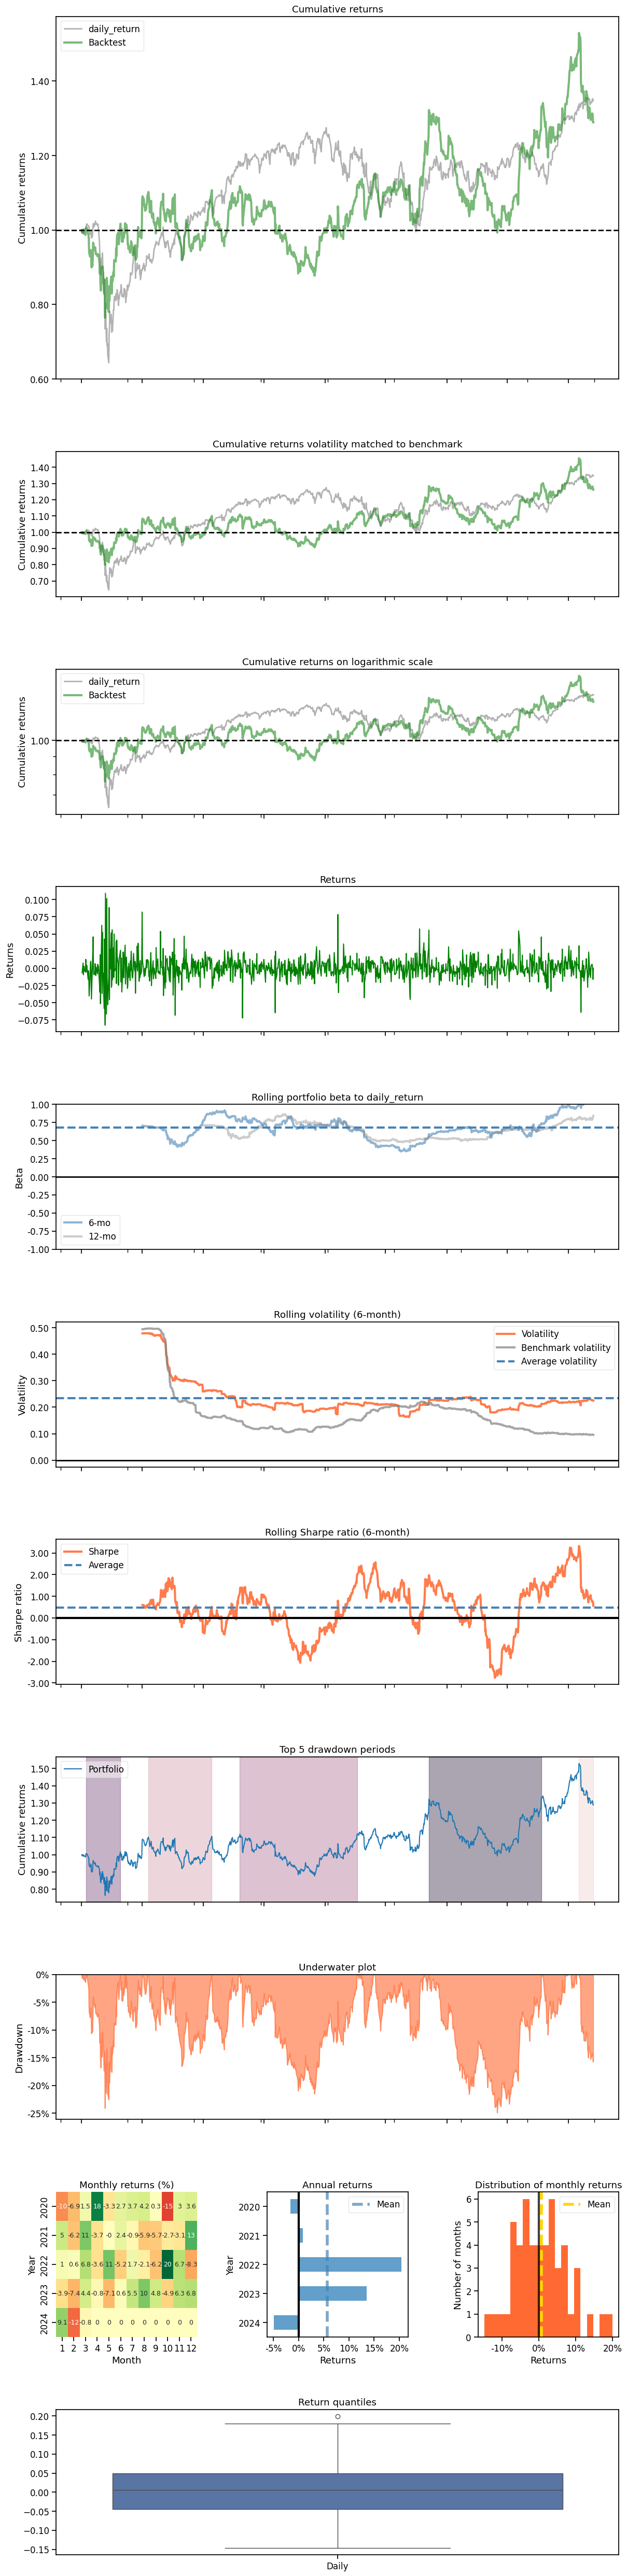

In [152]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [130]:
# print(DOW_30_TICKER)
test_portfolio = DOW_30_TICKER[:2]
len(test_portfolio)

2

In [131]:
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [126]:
# df_stock_test_ = get_baseline(
#         ticker='AXP', 
#         start = TEST_START_DATE,
#         end = TEST_END_DATE)
# df_stock_test_

In [127]:
# for field in modify_fields:
#     df_stock_test_[field] = df_stock_test_[field]/df_stock_test_.iloc[0][field]/len(test_portfolio)
# df_stock_test_ = df_stock_test_[used_columns]

In [132]:
daily_account_value.shape

(1058, 2)

In [153]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (1057, 8)
Shape of DataFrame:  (1057, 8)
Annual return          0.113655
Cumulative returns     0.571369
Annual volatility      0.272331
Sharpe ratio           0.530754
Calmar ratio           0.322387
Stability              0.732961
Max drawdown          -0.352541
Omega ratio            1.105579
Sortino ratio          0.796600
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051671
Daily value at risk   -0.033737
dtype: float64


In [134]:
df_hold_

,date,close
0,2020-01-02,1.000000
1,2020-01-03,0.991639
2,2020-01-06,0.993305
3,2020-01-07,0.986016
4,2020-01-08,0.994853
...,...,...
1053,2024-03-11,1.579257
1054,2024-03-12,1.592400
1055,2024-03-13,1.591768
1056,2024-03-14,1.571369


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [131]:
# df_hold_.date = pd.to_datetime(df_hold_['date'])
# df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
# df_hold_.bfill(inplace=True)
# df_hold_

In [154]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2020-01-02  1.000000e+06
2020-01-03  9.916392e+05
2020-01-06  9.933047e+05
2020-01-07  9.860160e+05
2020-01-08  9.948534e+05
...                  ...
2024-03-11  1.579257e+06
2024-03-12  1.592400e+06
2024-03-13  1.591768e+06
2024-03-14  1.571369e+06
2024-03-15  1.571369e+06

[1058 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2020-01-02  1.000000e+06  1.000000e+06
2020-01-02  9.990001e+05  1.000000e+06
2020-01-03  9.922118e+05  9.916392e+05
2020-01-03  9.922118e+05  9.916392e+05
2020-01-06  9.998330e+05  9.933047e+05
...                  ...           ...
2024-03-12  1.311546e+06  1.592400e+06
2024-03-13  1.308936e+06  1.591768e+06
2024-03-13  1.308936e+06  1.591768e+06
2024-03-14  1.287816e+06  1.571369e+06
2024-03-14  1.287816e+06  1.571369e+06

[2114 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

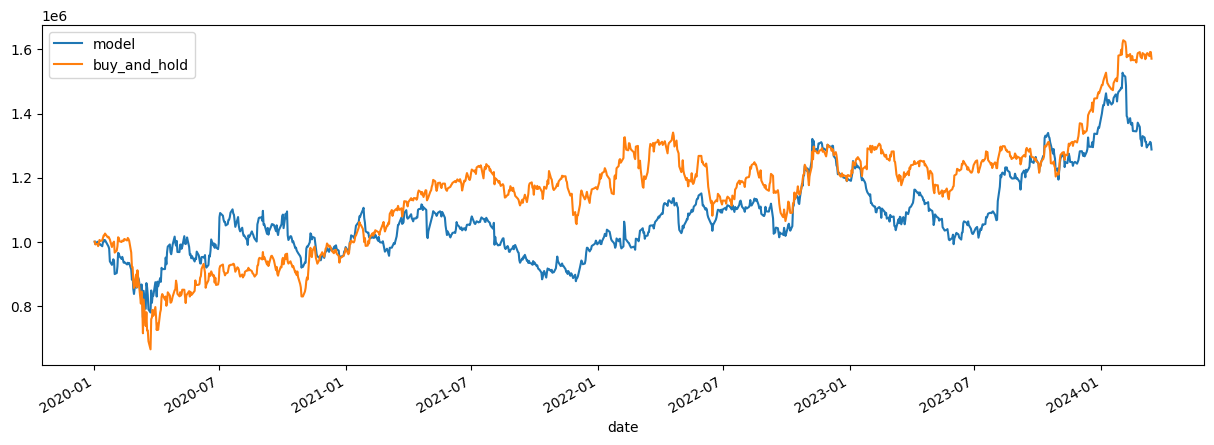

In [155]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [156]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [157]:
model_name = "./"+TRAINED_MODEL_DIR+"/ppo_model_384steps"
model_name

'./trained_models/ppo_model_384steps'

In [158]:
trained_ppo.save(model_name)

### 8.1.2 Save model as ONNX file

In [153]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [144]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [48]:
onnx_policy = OnnxableSB3Policy(trained_sac.policy)
observation_size = trained_sac.observation_space.shape
dummy_input = th.randn(1, *observation_size)

th.onnx.export(
    onnx_policy,
    dummy_input,
    "sac_model_1200k_sac9.onnx",
    opset_version=17,
    input_names=["input"],
)

<a id='7.2'></a>
## 8.2 Load model

### 8.2.1 Load trained model

In [341]:
from stable_baselines3 import SAC
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [342]:
model_name = "./"+TRAINED_MODEL_DIR+"/sac_model_1200k_sac9"
model_name

'./trained_models/sac_model_1200k_sac9'

In [343]:
trained_model = SAC.load(model_name)

Continous training based on the previous model

In [355]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

In [356]:
agent_sac = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

In [357]:
episode_length = len(e_train_gym.df) + 1
episode_amount = 8
total_training_step = episode_length*episode_amount
trained_model.env = env_train

In [358]:
trained_sac = agent_sac.train_model(model=trained_model, 
                             tb_log_name='sac',
                             total_timesteps=total_training_step)

Logging to tensorboard_log/test_sac/sac_11
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 60        |
|    time_elapsed    | 1457      |
|    total_timesteps | 87928     |
| train/             |           |
|    actor_loss      | 2.92e+08  |
|    critic_loss     | 1.66e+16  |
|    ent_coef        | 2.06e+07  |
|    ent_coef_loss   | -9.83     |
|    learning_rate   | 0.0003    |
|    n_updates       | 1298402   |
|    reward          | 0.7721382 |
----------------------------------
---------------------------------------
| time/              |                |
|    episodes        | 8              |
|    fps             | 55             |
|    time_elapsed    | 3167           |
|    total_timesteps | 175856         |
| train/             |                |
|    actor_loss      | -9.5e+09       |
|    critic_loss     | 7.87e+19       |
|    ent_coef        | 5.35e+05       |
|    ent_coef_loss   | 15.5     

#### Test loaded model

In [ ]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [ ]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

In [ ]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [ ]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)